## Portfolio simulation

In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from functions.portfolio_simulation_class import PortfolioSimulation
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from code.functions.faster_portfolio_simulation_class import PortfolioSimulation_fast
# import re
# import math 

In [2]:
# Stock prices
stock_prices = pd.read_csv("../data/sp1500_monthly_prices.csv", dtype={"cik": str})
# Risk free rate df
risk_free_rate_df = pd.read_csv("../data/us3mt_yield_curve.csv")

- Function to preprocess signals to what the PF simulation class expects

In [3]:
def extract_signal(text):
    # Normalize text: lowercase, remove punctuation, remove extra spaces
    text_clean = ''.join(c for c in text.lower())
    
    # Map strong signals to regular ones
    if 'strong buy' in text_clean:
        return 'buy'
    if 'strong sell' in text_clean:
        return 'sell'
    if 'buy' in text_clean:
        return 'buy'
    if 'sell' in text_clean:
        return 'sell'
    if 'hold' in text_clean:
        return 'hold'
    return None 

---
- Reading in the recommendations dfs

In [4]:
# Read in CIK as string, so that leading zeros are preserved
analyst_ratings = pd.read_csv("../data/sp1500_sell_side_recommendations_ffilled.csv", dtype={"cik": str})
analyst_ratings.head()

,cik,date,mean_rating,rating,security
0,0000001750,2000-01,1.71429,buy,AAR CORP.
1,0000001750,2000-02,1.71429,buy,AAR CORP.
2,0000001750,2000-03,1.71429,buy,AAR CORP.
3,0000001750,2000-04,1.50000,strong buy,AAR CORP.
4,0000001750,2000-05,1.50000,strong buy,AAR CORP.


In [5]:
# LLM recommendations with only most recent financial statements
llm_recommendations1 = pd.read_csv("../data/ciklist1_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations2 = pd.read_csv("../data/ciklist2_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations3 = pd.read_csv("../data/ciklist3_ratings_with_most_recent_quarters.csv", dtype={"cik": str})
llm_recommendations4 = pd.read_csv("../data/missing_ratings.csv", dtype={"cik": str})

# Combine into one DataFrame
llm_recommendations = pd.concat([llm_recommendations1, llm_recommendations2, llm_recommendations3, llm_recommendations4], ignore_index=True)
llm_recommendations.head()

,cik,date,rating
0,0001497645,2010-03-31,sell
1,0001497645,2010-06-30,sell
2,0001497645,2010-09-30,sell
3,0001497645,2010-12-31,sell
4,0001497645,2011-03-31,sell


In [6]:
# Read in LLM recommendations with previous quarters
llm_recommendations_w_prev_quarters1 = pd.read_csv("../data/ciklist1_ratings_with_previous_quarters.csv", dtype={"cik": str})
llm_recommendations_w_prev_quarters2 = pd.read_csv("../data/ciklist2_ratings_with_previous_quarters.csv", dtype={"cik": str})
llm_recommendations_w_prev_quarters3 = pd.read_csv("../data/ciklist3_ratings_with_previous_quarters.csv", dtype={"cik": str})
llm_recommendations_w_prev_quarters4 = pd.read_csv("../data/missing_ratings_with_previous_quarters.csv", dtype={"cik": str})

# Combine into one DataFrame
llm_recommendations_w_prev_quarters = pd.concat([llm_recommendations_w_prev_quarters1, llm_recommendations_w_prev_quarters2, llm_recommendations_w_prev_quarters3, llm_recommendations_w_prev_quarters4])
llm_recommendations_w_prev_quarters.head()

,cik,date,rating
0,0001576018,2013-03-31,buy
1,0001576018,2013-06-30,hold
2,0001576018,2013-09-30,buy
3,0001576018,2013-12-31,hold
4,0001576018,2014-03-31,hold


---

- Subsetting CIK date combinations that are present in all dataframes

In [7]:
 # Apply function
llm_recommendations["action"] = llm_recommendations["rating"].apply(extract_signal)
analyst_ratings["action"] = analyst_ratings["rating"].apply(extract_signal)
llm_recommendations_w_prev_quarters["action"] = llm_recommendations_w_prev_quarters["rating"].apply(extract_signal)

# Convert date to period format
llm_recommendations["date"] = pd.to_datetime(llm_recommendations["date"]).dt.to_period("M").astype(str)
analyst_ratings["date"] = pd.to_datetime(analyst_ratings["date"]).dt.to_period("M").astype(str)
llm_recommendations_w_prev_quarters["date"] = pd.to_datetime(llm_recommendations_w_prev_quarters["date"]).dt.to_period("M").astype(str)

# Drop duplicates
llm_recommendations.drop_duplicates(subset=["cik", "date"], inplace=True)
analyst_ratings.drop_duplicates(subset=["cik", "date"], inplace=True)
llm_recommendations_w_prev_quarters.drop_duplicates(subset=["cik", "date"], inplace=True)

In [8]:
# Subsetting unique CIK and date combinations from both datasets
llm_ciks_and_dates = llm_recommendations[["cik", "date"]].drop_duplicates()
analyst_ciks_and_dates = analyst_ratings[["cik", "date"]].drop_duplicates()
llm_prev_quarters_ciks_and_dates = llm_recommendations_w_prev_quarters[["cik", "date"]].drop_duplicates()

# Merge to find common CIK and date combinations
llm_cik_and_dates_all = pd.merge(llm_ciks_and_dates, llm_prev_quarters_ciks_and_dates, on=["cik", "date"], how="inner")
all_ciks_and_dates = pd.merge(llm_cik_and_dates_all, analyst_ciks_and_dates, on=["cik", "date"], how="inner")

In [9]:
# Only keep CIK date combinations that are in both datasets
llm_recommendations_final = pd.merge(
    llm_recommendations, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
analyst_ratings_final = pd.merge(
    analyst_ratings, all_ciks_and_dates, on=["cik", "date"], how="inner"
)
llm_recommendations_w_prev_quarters_final = pd.merge(
    llm_recommendations_w_prev_quarters, all_ciks_and_dates, on=["cik", "date"], how="inner"
)

len(llm_recommendations_final), len(analyst_ratings_final), len(llm_recommendations_w_prev_quarters_final)

(112847, 112847, 112847)

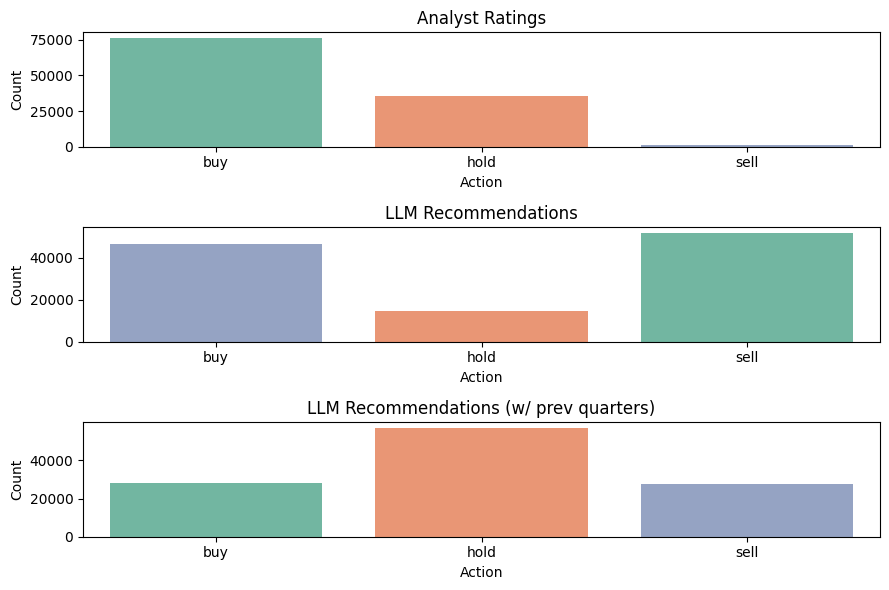

In [10]:
datasets = [
    ("Analyst Ratings", analyst_ratings_final),
    ("LLM Recommendations", llm_recommendations_final),
    ("LLM Recommendations (w/ prev quarters)", llm_recommendations_w_prev_quarters_final)
]

plt.figure(figsize=(9, 6))

for i, (title, df) in enumerate(datasets, 1):
    plt.subplot(3, 1, i)
    sns.countplot(x='action', hue='action', data=df, order=['buy', 'hold', 'sell'], palette='Set2', legend=False)
    plt.title(title)
    plt.ylabel('Count')
    plt.xlabel('Action')

plt.tight_layout()
plt.show()


---
### Subsetting a time period for testing

In [11]:
# Test period timeframe
test_period = (2000, 2005)

In [12]:
# Converting date column in all ratings to datetime for filtering
llm_recommendations_final["date"] = pd.to_datetime(llm_recommendations_final['date']).dt.to_period('M')
analyst_ratings_final["date"] = pd.to_datetime(analyst_ratings_final['date']).dt.to_period('M')
llm_recommendations_w_prev_quarters_final["date"] = pd.to_datetime(llm_recommendations_w_prev_quarters_final['date']).dt.to_period('M')

In [13]:
# Filtering ratings
llm_recommendations_testing = llm_recommendations_final[
    (llm_recommendations_final["date"].dt.year >= test_period[0]) &
    (llm_recommendations_final["date"].dt.year <= test_period[1])
].copy()
analyst_ratings_testing = analyst_ratings_final[
    (analyst_ratings_final["date"].dt.year >= test_period[0]) &
    (analyst_ratings_final["date"].dt.year <= test_period[1])
].copy()
llm_recommendations_w_prev_quarters_testing = llm_recommendations_w_prev_quarters_final[
    (llm_recommendations_w_prev_quarters_final["date"].dt.year >= test_period[0]) &
    (llm_recommendations_w_prev_quarters_final["date"].dt.year <= test_period[1])
].copy()
llm_recommendations_testing["date"].max(), llm_recommendations_testing["date"].min(),analyst_ratings_testing["date"].max(), analyst_ratings_testing["date"].min(),
llm_recommendations_w_prev_quarters_testing["date"].max(), llm_recommendations_w_prev_quarters_testing["date"].min()

(Period('2005-12', 'M'), Period('2000-01', 'M'))

In [14]:
# Converting date back to str
llm_recommendations_testing["date"] = llm_recommendations_testing["date"].astype(str)
analyst_ratings_testing["date"] = analyst_ratings_testing["date"].astype(str)
llm_recommendations_w_prev_quarters_testing["date"] = llm_recommendations_w_prev_quarters_testing["date"].astype(str)
llm_recommendations_testing

,cik,date,rating,action
52,0000066004,2000-03,sell,sell
53,0000066004,2000-06,sell,sell
54,0000066004,2000-09,hold,hold
55,0000066004,2000-12,sell,sell
56,0000066004,2001-03,hold,hold
...,...,...,...,...
112725,0001031296,2004-12,sell,sell
112726,0001031296,2005-03,hold,hold
112727,0001031296,2005-06,hold,hold
112728,0001031296,2005-09,buy,buy


---
### Test simulation 

In [15]:
ciks = llm_recommendations_testing["cik"].unique()[:6]
ciks

array(['0000066004', '0000027996', '0001158463', '0000831259',
       '0000886982', '0000106640'], dtype=object)

In [17]:
# Subset CIKs for testing
cik_prices = stock_prices[stock_prices["cik"].isin([ciks][0])]
cik_llm_recommendations = llm_recommendations_testing[llm_recommendations_testing["cik"].isin([ciks][0])]

In [18]:
start_capital = 1000000
cik_sim = PortfolioSimulation(initial_capital = start_capital)
cik_sim.load_dataframes(cik_prices, cik_llm_recommendations, risk_free_rate_df) 
cik_sim.partial_shares = True

# Run simulation
cik_sim.simulate_trading()

Simulating Trades:   0%|          | 0/47 [00:00<?, ?it/s]

Simulating Trades: 100%|██████████| 47/47 [00:00<00:00, 449.05it/s]


In [19]:
stats = cik_sim.portfolio_statistics()
stats

Calculating Monthly Returns: 100%|██████████| 70/70 [00:00<00:00, 375.17it/s]


{'Mean return (monthly)': np.float64(0.01429),
 'Geometric mean return (monthly)': np.float64(0.012217),
 'Standard deviation (monthly)': np.float64(0.067787),
 'Annualized mean return': np.float64(0.156872),
 'Annualized standard deviation': np.float64(0.23482),
 'Annualized Sharpe Ratio': np.float64(0.619391),
 'Number of buy signals': 26,
 'Number of sell signals': 84,
 'Number of hold signals': 19,
 'Number of signals': 129,
 'Number of executed buys': 26,
 'Number of executed sells': 25,
 'Number of executed transactions': 51,
 'Number of skipped buys': 0,
 'Number of skipped sells': 0,
 'Total number of skipped transactions': 19,
 'Overall transaction count': 70,
 'Number of recommendations': 134,
 'Final Portfolio value (normalized)': np.float64(2.3397163431)}

In [20]:
cik_returns = cik_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 70/70 [00:00<00:00, 384.01it/s]


In [22]:
cik_sim_cached = PortfolioSimulation_cached()
cik_sim_cached.load_dataframes(cik_prices, cik_llm_recommendations, risk_free_rate_df)
cik_sim_cached.partial_shares = True
cik_sim_cached.simulate_trading()

Simulating Trades: 100%|██████████| 47/47 [00:00<00:00, 478.66it/s]


In [23]:
cik_returns_cached = cik_sim_cached.calculate_monthly_returns()
cik_stats_cached = cik_sim_cached.portfolio_statistics(monthly_returns = cik_returns_cached)
cik_stats_cached

Computing Monthly PF values: 100%|██████████| 71/71 [00:00<00:00, 566.73it/s]


{'Mean return (monthly)': np.float64(0.01429),
 'Geometric mean return (monthly)': np.float64(0.012217),
 'Standard deviation (monthly)': np.float64(0.067787),
 'Annualized mean return': np.float64(0.156871),
 'Annualized standard deviation': np.float64(0.23482),
 'Annualized Sharpe Ratio': np.float64(0.61939),
 'Number of buy signals': 26,
 'Number of sell signals': 84,
 'Number of hold signals': 19,
 'Number of signals': 129,
 'Number of executed buys': 26,
 'Number of executed sells': 25,
 'Number of executed transactions': 51,
 'Number of skipped buys': 0,
 'Number of skipped sells': 0,
 'Total number of skipped transactions': 19,
 'Overall transaction count': 70,
 'Number of recommendations': 134,
 'Final Portfolio value (normalized)': np.float64(2.3397163431)}

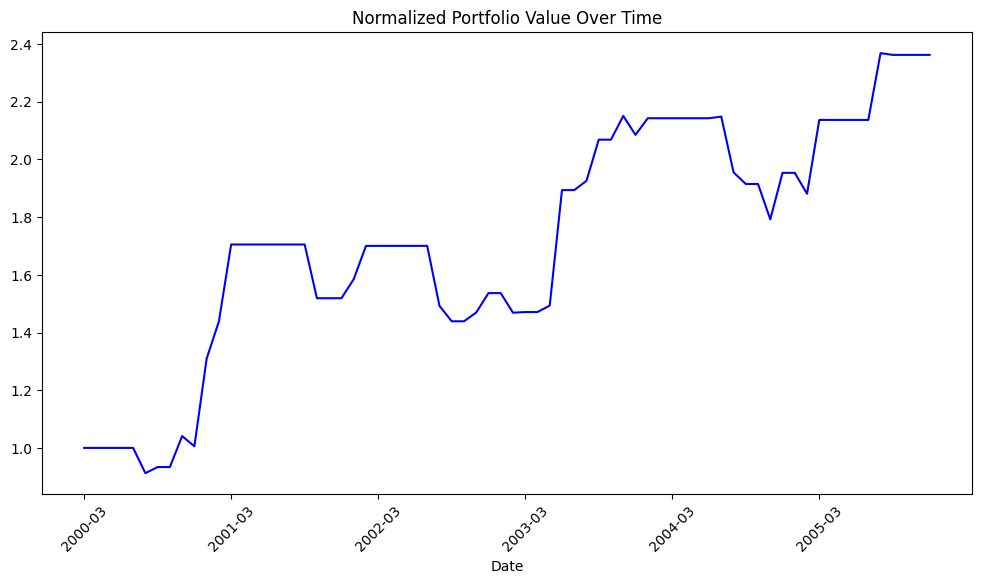

In [26]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = cik_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6))
plt.plot(dates, cik_returns['normalized_start_value'], label='PF at start of month', color='blue')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.show()

---
## Simulations

### LLM recomendations with most recent financial statements

In [22]:
# Set global variables for all simulations
start_capital = 10000000

# Initialize portfolio simulation
llm_sim = PortfolioSimulation(initial_capital=start_capital)
llm_sim.partial_shares = True

# Load data
llm_sim.load_dataframes(stock_prices, llm_recommendations_testing, risk_free_rate_df)
# Run simulation
llm_sim.simulate_trading()

Simulating Trades: 100%|██████████| 71/71 [03:45<00:00,  3.18s/it]


In [23]:
llm_recommendations[llm_recommendations["cik"] == "0001067983"]

,cik,date,rating,action
31778,0001067983,1999-03,sell,sell
31779,0001067983,1999-06,sell,sell
31780,0001067983,1999-09,buy,buy
31781,0001067983,1999-12,buy,buy
31782,0001067983,2000-03,hold,hold
...,...,...,...,...
31873,0001067983,2022-12,buy,buy
31874,0001067983,2023-03,hold,hold
31875,0001067983,2023-06,buy,buy
31876,0001067983,2023-09,sell,sell


In [24]:
llm_returns = llm_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 71/71 [03:42<00:00,  3.14s/it]


In [25]:
llm_sim.portfolio_statistics(monthly_returns =  llm_returns)

{'Mean return (monthly)': np.float64(0.024462),
 'Geometric mean return (monthly)': np.float64(0.023187),
 'Standard deviation (monthly)': np.float64(0.051062),
 'Annualized mean return': np.float64(0.316617),
 'Annualized standard deviation': np.float64(0.176883),
 'Annualized Sharpe Ratio': np.float64(1.506675),
 'Number of buy signals': 8239,
 'Number of sell signals': 9416,
 'Number of hold signals': 3201,
 'Number of signals': 20856,
 'Number of executed buys': 8103,
 'Number of executed sells': 8080,
 'Number of executed transactions': 16183,
 'Number of skipped buys': 136,
 'Number of skipped sells': 0,
 'Total number of skipped transactions': 3337,
 'Overall transaction count': 19520,
 'Number of recommendations': 21705,
 'Final Portfolio value (normalized)': np.float64(5.091003163050001)}

---

### LLM recommendations with previous quarters

In [26]:
# Initialize portfolio simulation
llm_sim2 = PortfolioSimulation(initial_capital=start_capital)
llm_sim2.partial_shares = True

# Load data
llm_sim2.load_dataframes(stock_prices, llm_recommendations_w_prev_quarters_testing, risk_free_rate_df)

# Run simulation
llm_sim2.simulate_trading()

Simulating Trades: 100%|██████████| 71/71 [02:33<00:00,  2.16s/it]


In [27]:
llm_returns2 = llm_sim2.calculate_monthly_returns()

Calculating Monthly Returns:   0%|          | 0/71 [00:00<?, ?it/s]

Calculating Monthly Returns: 100%|██████████| 71/71 [02:33<00:00,  2.16s/it]


In [28]:
llm_sim2.portfolio_statistics(monthly_returns =  llm_returns2)

{'Mean return (monthly)': np.float64(0.022724),
 'Geometric mean return (monthly)': np.float64(0.021006),
 'Standard deviation (monthly)': np.float64(0.059097),
 'Annualized mean return': np.float64(0.28334),
 'Annualized standard deviation': np.float64(0.204717),
 'Annualized Sharpe Ratio': np.float64(1.198932),
 'Number of buy signals': 5612,
 'Number of sell signals': 5438,
 'Number of hold signals': 9806,
 'Number of signals': 20856,
 'Number of executed buys': 5505,
 'Number of executed sells': 5491,
 'Number of executed transactions': 10996,
 'Number of skipped buys': 107,
 'Number of skipped sells': 0,
 'Total number of skipped transactions': 9913,
 'Overall transaction count': 20909,
 'Number of recommendations': 21705,
 'Final Portfolio value (normalized)': np.float64(4.37543511515)}

---
### Analyst recommendations simulation

In [29]:
analyst_sim = PortfolioSimulation(initial_capital=start_capital)
analyst_sim.partial_shares = True
analyst_sim.load_dataframes(stock_prices, analyst_ratings_testing, risk_free_rate_df)
analyst_sim.simulate_trading()

Simulating Trades:   0%|          | 0/71 [00:00<?, ?it/s]

Simulating Trades: 100%|██████████| 71/71 [06:33<00:00,  5.54s/it]


In [30]:
len(stock_prices), len(analyst_ratings_final)

(355365, 112847)

In [31]:
analyst_returns = analyst_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 71/71 [06:29<00:00,  5.48s/it]


In [32]:
analyst_sim.portfolio_statistics(monthly_returns =  analyst_returns)

{'Mean return (monthly)': np.float64(0.018772),
 'Geometric mean return (monthly)': np.float64(0.017399),
 'Standard deviation (monthly)': np.float64(0.052718),
 'Annualized mean return': np.float64(0.229969),
 'Annualized standard deviation': np.float64(0.182622),
 'Annualized Sharpe Ratio': np.float64(1.086442),
 'Number of buy signals': 14304,
 'Number of sell signals': 308,
 'Number of hold signals': 6244,
 'Number of signals': 20856,
 'Number of executed buys': 13889,
 'Number of executed sells': 13855,
 'Number of executed transactions': 27744,
 'Number of skipped buys': 415,
 'Number of skipped sells': 0,
 'Total number of skipped transactions': 6659,
 'Overall transaction count': 34403,
 'Number of recommendations': 21705,
 'Final Portfolio value (normalized)': np.float64(3.40310111738)}

In [33]:
sp_1500_prices = pd.read_csv("../data/sp1500_composite_index_prices.csv")
sp_1500_prices["normalized"] = sp_1500_prices["price"] / sp_1500_prices["price"].iloc[0]

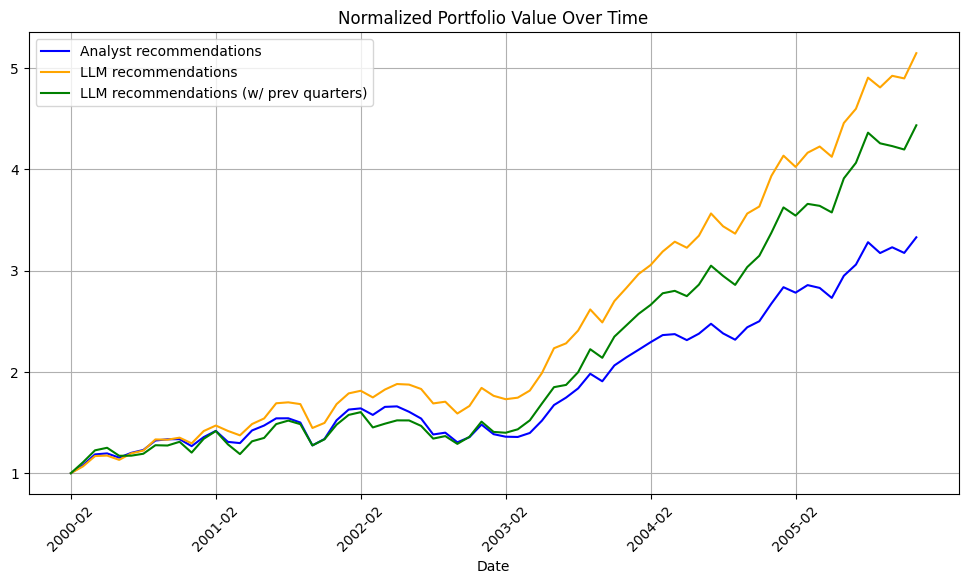

In [34]:
# plot start value over time
dates = analyst_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6)) 
plt.plot(dates, analyst_returns['normalized_start_value'], label='Analyst recommendations', color='blue')
plt.plot(dates, llm_returns['normalized_start_value'], label='LLM recommendations', color='orange')
plt.plot(dates, llm_returns2['normalized_start_value'], label='LLM recommendations (w/ prev quarters)', color='green')
#plt.plot(sp_1500_prices["date"], sp_1500_prices['normalized'], label='S&P 1500 Index (different companies)', color='red')
#plt.plot(stock_prices_sum_df["date"], stock_prices_sum_df['normalized_sum'], label='Stock Prices', color='purple')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.grid()
plt.legend()
plt.show()

---

### Validation period: Comparing analyst PF to best-performing LLM PF across the remaining time-span

The PF simulation following LLM recommendations obtained by inputting only the most recent financial statements, exhibits the best Sharpe Ratio and will therefore be 
regarded for the validation period.

In [27]:
# Set validation period
val_period = (2006, 2025)

In [28]:
llm_recommendations_val = llm_recommendations_final[llm_recommendations_final["date"].dt.year >= val_period[0]].copy()
analyst_ratings_val = analyst_ratings_final[analyst_ratings_final["date"].dt.year >= val_period[0]].copy()
llm_recommendations_val["date"].min(), llm_recommendations_val["date"].max(), analyst_ratings_val["date"].min(), analyst_ratings_val["date"].max()

(Period('2006-01', 'M'),
 Period('2024-11', 'M'),
 Period('2006-01', 'M'),
 Period('2024-11', 'M'))

In [29]:
llm_recommendations_val["date"] = llm_recommendations_val["date"].astype(str)
analyst_ratings_val["date"] = analyst_ratings_val["date"].astype(str)

- LLM simulation

In [30]:
final_llm_sim = PortfolioSimulation()
final_llm_sim.partial_shares = True
final_llm_sim.load_dataframes(stock_prices, llm_recommendations_val, risk_free_rate_df)


# Run simulation
start_time = datetime.now()
final_llm_sim.simulate_trading()
end_time = datetime.now()
elapsed = (end_time - start_time ) # timedelta object
minutes = elapsed.total_seconds() / 60
print(f"Simulation took {minutes:.2f} minutes")

Simulating Trades: 100%|██████████| 226/226 [18:10<00:00,  4.83s/it]

Simulation took 18.18 minutes


In [31]:
final_llm_returns = final_llm_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 226/226 [17:32<00:00,  4.66s/it]


In [32]:
final_llm_sim.portfolio_statistics(monthly_returns = final_llm_returns)

{'Mean return (monthly)': np.float64(0.020261),
 'Geometric mean return (monthly)': np.float64(0.018721),
 'Standard deviation (monthly)': np.float64(0.055654),
 'Annualized mean return': np.float64(0.249285),
 'Annualized standard deviation': np.float64(0.192791),
 'Annualized Sharpe Ratio': np.float64(1.183085),
 'Number of buy signals': 37725,
 'Number of sell signals': 41701,
 'Number of hold signals': 11150,
 'Number of signals': 90576,
 'Number of executed buys': 37632,
 'Number of executed sells': 37622,
 'Number of executed transactions': 75254,
 'Number of skipped buys': 93,
 'Number of skipped sells': 0,
 'Total number of skipped transactions': 11243,
 'Overall transaction count': 86497,
 'Number of recommendations': 90582,
 'Final Portfolio value (normalized)': np.float64(66.1388509467)}

- Analyst simulation

In [33]:
final_analyst_sim = PortfolioSimulation()
final_analyst_sim.partial_shares = True
final_analyst_sim.load_dataframes(stock_prices, analyst_ratings_val, risk_free_rate_df)


# Run simulation
start_time = datetime.now()
final_analyst_sim.simulate_trading()
end_time = datetime.now()
elapsed = (end_time - start_time)  # timedelta object
minutes = elapsed.total_seconds() / 60
print(f"Simulation took {minutes:.2f} minutes")

Simulating Trades: 100%|██████████| 226/226 [28:48<00:00,  7.65s/it]

Simulation took 28.81 minutes


In [34]:
final_analyst_returns = final_analyst_sim.calculate_monthly_returns()

Calculating Monthly Returns: 100%|██████████| 226/226 [28:02<00:00,  7.44s/it]


In [35]:
final_analyst_sim.portfolio_statistics(monthly_returns = final_analyst_returns)

{'Mean return (monthly)': np.float64(0.015752),
 'Geometric mean return (monthly)': np.float64(0.014154),
 'Standard deviation (monthly)': np.float64(0.056475),
 'Annualized mean return': np.float64(0.183719),
 'Annualized standard deviation': np.float64(0.195637),
 'Annualized Sharpe Ratio': np.float64(0.889239),
 'Number of buy signals': 61014,
 'Number of sell signals': 717,
 'Number of hold signals': 28845,
 'Number of signals': 90576,
 'Number of executed buys': 60657,
 'Number of executed sells': 60645,
 'Number of executed transactions': 121302,
 'Number of skipped buys': 357,
 'Number of skipped sells': 0,
 'Total number of skipped transactions': 29202,
 'Overall transaction count': 150504,
 'Number of recommendations': 90582,
 'Final Portfolio value (normalized)': np.float64(23.9615306046)}

- Plot of PF development over time (normalized)

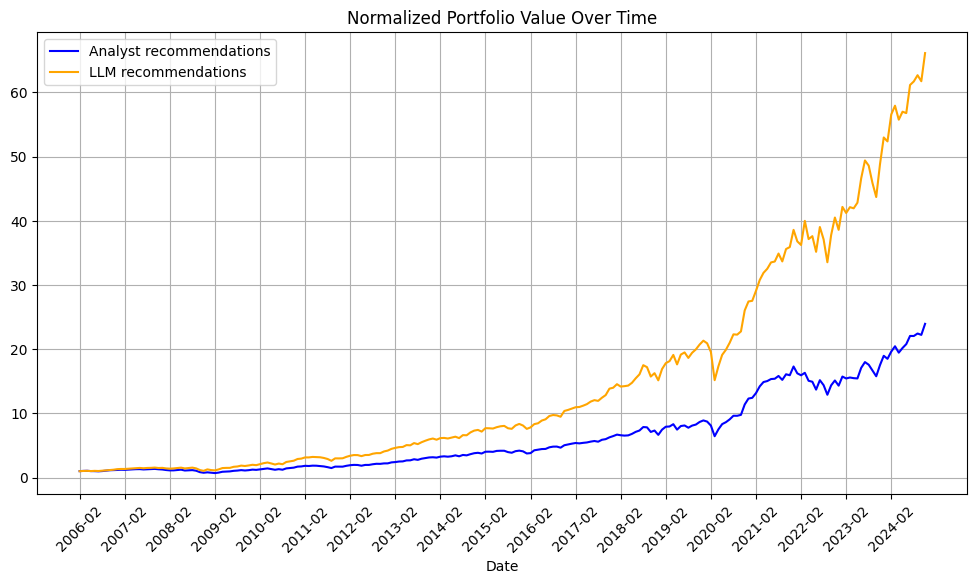

In [36]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = final_analyst_returns["month"].unique().astype(str)
plt.figure(figsize=(12, 6)) 
plt.plot(dates, final_analyst_returns['normalized_end_value'], label='Analyst recommendations', color='blue')
plt.plot(dates, final_llm_returns['normalized_end_value'], label='LLM recommendations', color='orange')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.grid()
plt.legend()
plt.show()

---

New PF simulation class including cached positions

In [37]:
final_llm_sim_cached = PortfolioSimulation_cached()
final_llm_sim_cached.partial_shares = True
final_llm_sim_cached.load_dataframes(stock_prices, llm_recommendations_val, risk_free_rate_df)


# Run simulation
start_time = datetime.now()
final_llm_sim_cached.simulate_trading()
end_time = datetime.now()
elapsed = (end_time - start_time)  # timedelta object
minutes = elapsed.total_seconds() / 60
print(f"Simulation took {minutes:.2f} minutes")


Simulating Trades: 100%|██████████| 226/226 [17:25<00:00,  4.63s/it]

Simulation took 17.43 minutes


In [38]:
start_time = datetime.now()
final_llm_returns_cached = final_llm_sim_cached.calculate_monthly_returns()
end_time = datetime.now()
elapsed = (end_time - start_time)  # timedelta object
minutes = elapsed.total_seconds() / 60
print(f"Calculating returns took {minutes:.2f} minutes")

Computing Monthly PF values: 100%|██████████| 227/227 [08:41<00:00,  2.30s/it]

Calculating returns took 8.70 minutes


In [39]:
final_llm_sim_cached.portfolio_statistics(monthly_returns = final_llm_returns_cached)

{'Mean return (monthly)': np.float64(0.020261),
 'Geometric mean return (monthly)': np.float64(0.018721),
 'Standard deviation (monthly)': np.float64(0.055654),
 'Annualized mean return': np.float64(0.249285),
 'Annualized standard deviation': np.float64(0.192791),
 'Annualized Sharpe Ratio': np.float64(1.183085),
 'Number of buy signals': 37725,
 'Number of sell signals': 41701,
 'Number of hold signals': 11150,
 'Number of signals': 90576,
 'Number of executed buys': 37632,
 'Number of executed sells': 37622,
 'Number of executed transactions': 75254,
 'Number of skipped buys': 93,
 'Number of skipped sells': 0,
 'Total number of skipped transactions': 11243,
 'Overall transaction count': 86497,
 'Number of recommendations': 90582,
 'Final Portfolio value (normalized)': np.float64(66.1388509467)}

In [40]:
final_analyst_sim_cached = PortfolioSimulation_cached()
final_analyst_sim_cached.partial_shares = True
final_analyst_sim_cached.load_dataframes(stock_prices, analyst_ratings_val, risk_free_rate_df)


# Run simulation
start_time = datetime.now()
final_analyst_sim_cached.simulate_trading()
end_time = datetime.now()
elapsed = (end_time - start_time)  # timedelta object
minutes = elapsed.total_seconds() / 60
print(f"Simulation took {minutes:.2f} minutes")

Simulating Trades: 100%|██████████| 226/226 [28:18<00:00,  7.52s/it]

Simulation took 28.31 minutes


In [41]:
start_time = datetime.now()
final_analyst_returns_cached = final_analyst_sim_cached.calculate_monthly_returns()
end_time = datetime.now()
elapsed = (end_time - start_time)  # timedelta object
minutes = elapsed.total_seconds() / 60
print(f"Calculating returns took {minutes:.2f} minutes")


Computing Monthly PF values: 100%|██████████| 227/227 [14:27<00:00,  3.82s/it]

Calculating returns took 14.45 minutes


In [45]:
final_analyst_sim_cached.portfolio_statistics(monthly_returns = final_analyst_returns_cached)

{'Mean return (monthly)': np.float64(0.015752),
 'Geometric mean return (monthly)': np.float64(0.014154),
 'Standard deviation (monthly)': np.float64(0.056475),
 'Annualized mean return': np.float64(0.183719),
 'Annualized standard deviation': np.float64(0.195637),
 'Annualized Sharpe Ratio': np.float64(0.889238),
 'Number of buy signals': 61014,
 'Number of sell signals': 717,
 'Number of hold signals': 28845,
 'Number of signals': 90576,
 'Number of executed buys': 60657,
 'Number of executed sells': 60645,
 'Number of executed transactions': 121302,
 'Number of skipped buys': 357,
 'Number of skipped sells': 0,
 'Total number of skipped transactions': 29202,
 'Overall transaction count': 150504,
 'Number of recommendations': 90582,
 'Final Portfolio value (normalized)': np.float64(23.9615306046)}

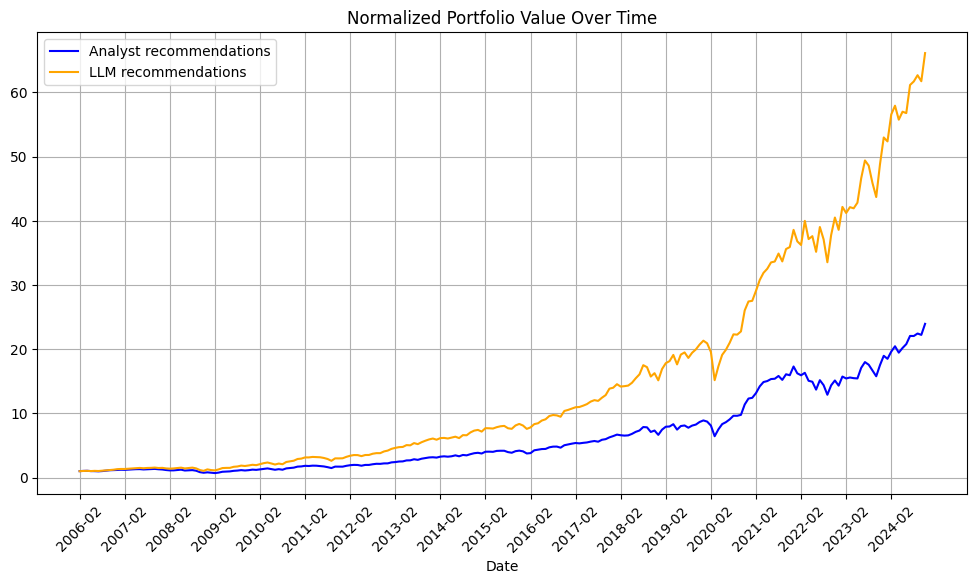

In [43]:
# plot start value over time
import matplotlib.pyplot as plt 
dates = final_analyst_returns_cached["month"].unique().astype(str)
plt.figure(figsize=(12, 6)) 
plt.plot(dates, final_analyst_returns_cached['normalized_end_value'], label='Analyst recommendations', color='blue')
plt.plot(dates, final_llm_returns_cached['normalized_end_value'], label='LLM recommendations', color='orange')
plt.title('Normalized Portfolio Value Over Time')
plt.xlabel('Date')
plt.xticks(dates[::12], rotation=45)
plt.grid()
plt.legend()
plt.show()